<h1>Поиск коррозии на плитках<h1/>

<p>Импорт библиотек<p/>

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2022-04-01 15:51:45.331791: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/emelyanov/anaconda3/envs/deep_learning/lib/python3.9/site-packages/cv2/../../lib64:
2022-04-01 15:51:45.331816: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<p>Объявление функций<p/>

In [2]:
def jupyter_imshow(imgs, columns=2):
    fig = plt.figure(figsize=(15,15))
    fig.tight_layout()

    if isinstance(imgs, list):
        number_of_files = len(imgs)
        rows = number_of_files//columns
        if (number_of_files%columns != 0):
            rows += 1
        
        for i, img in enumerate(imgs):
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            fig.add_subplot(rows, columns, i+1)
            plt.axis("off")
            plt.imshow(img)
            
    elif isinstance(imgs, np.ndarray):
        imgs = cv2.cvtColor(imgs, cv2.COLOR_BGR2RGB)
        plt.axis("off")
        plt.imshow(imgs)
        
def preprocess_image_kernel(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(1, 1), 500)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 201, 4)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5, 5))
    thresh = cv2.morphologyEx(thresh,cv2.MORPH_OPEN, kernel)
    thresh = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE, kernel)

    return thresh

def find_area_approx(cnt):
    x,y,w,h = cv2.boundingRect(cnt)
    return w*h

def find_contours_best(orig_img, thresh_img):
    #with adaptive
    raw_contours_img = orig_img.copy()
    rect_img = orig_img.copy()    

    color = (0, 0, 255)
    thikness = 3

    contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:30] 
    
    cv2.drawContours(raw_contours_img, contours, -1, color, thikness)
    
    approx_list = []

    for cnt in contours:
        peri = cv2.arcLength(cnt,True)
        approx = cv2.approxPolyDP(cnt, 0.05 * peri, True)
        area = find_area_approx(approx)
        # add area filter by shape of plate and shape of table
        if len(approx) == 4 and area >= 20000 and area <= 180000:
            approx_list.append(approx)
            cv2.drawContours(rect_img, [approx], 0, color, thikness)
            
    return raw_contours_img, rect_img, approx_list

def show_grid(img, grid_size):
    grig_img = img.copy()
    height, width, channels = img.shape
    # draw gird
    for x in range(0, width-1, grid_size):
         cv2.line(grig_img, (x, 0), (x, height), (255, 0, 0), 1, 1)
    for y in range(0, height-1, grid_size):
         cv2.line(grig_img, (0, y), (height, y), (255, 0, 0), 1, 1)
            
    return grig_img

def crop_img(img, grid_size = 30):
    crops = []
    imgheight, imgwidth, channels = img.shape
    M = grid_size
    N = grid_size
    x1 = 0
    y1 = 0

    for y in range(0, imgheight, M):
        for x in range(0, imgwidth, N):
            if (imgheight - y) < M or (imgwidth - x) < N:
                break
                
            y1 = y + M
            x1 = x + N

            # check whether the patch width or height exceeds the image width or height
            if x1 >= imgwidth and y1 >= imgheight:
                x1 = imgwidth - 1
                y1 = imgheight - 1
                #Crop into patches of size MxN
                crops.append(img[y:y+M, x:x+N])
            elif y1 >= imgheight: # when patch height exceeds the image height
                y1 = imgheight - 1
                #Crop into patches of size MxN
                crops.append(img[y:y+M, x:x+N])
            elif x1 >= imgwidth: # when patch width exceeds the image width
                x1 = imgwidth - 1
                #Crop into patches of size MxN
                crops.append(img[y:y+M, x:x+N])
            else:
                #Crop into patches of size MxN
                crops.append(img[y:y+M, x:x+N])
                
    return crops

def find_grid_size(img):
    # size of wraped image will always same size
    w, h, _ = img.shape
    gcd_value = math.gcd(w, h)
    return int(gcd_value/4)

<h2>Обработка изображения<h2/>

<p>Оригинальное изображение<p/>

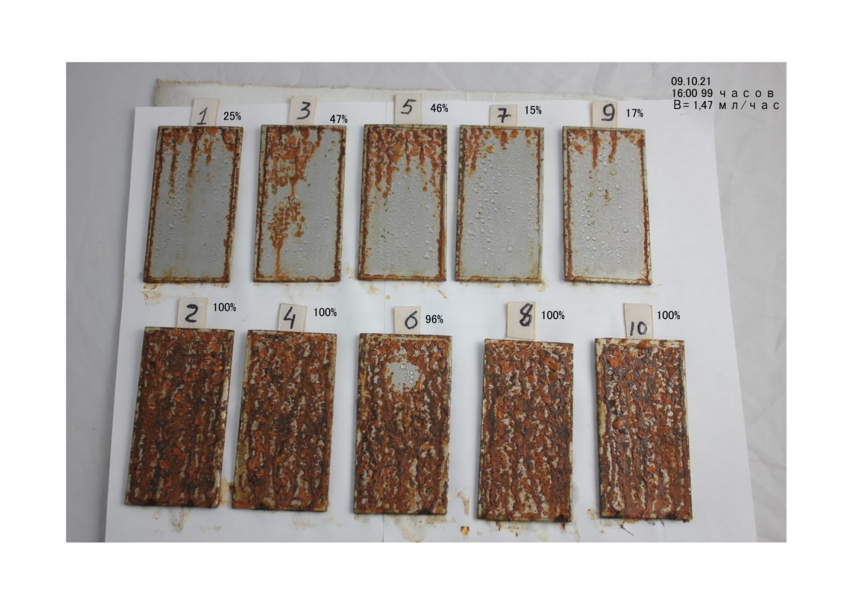

In [3]:
orig = cv2.imread('../metal_plates/image15.jpeg')
img = orig.copy()
jupyter_imshow(img)

<p>Поиск контуров на изображении<p/>

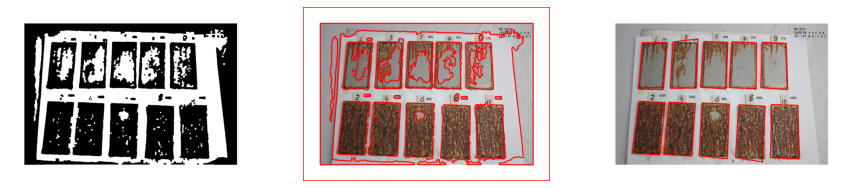

In [4]:
# получаем бинарное изображение (состоящее только из 0 и 1)
kernel_img = preprocess_image_kernel(img) 
# ищем контуры по бинарному изображению, отображаем и сохраняем их
raw_contours, rect_img, approx_best = find_contours_best(img, kernel_img) 
jupyter_imshow([kernel_img, raw_contours, rect_img], columns=3)

<p>Фото пластинок, выделенных по найденым контурам<p/>

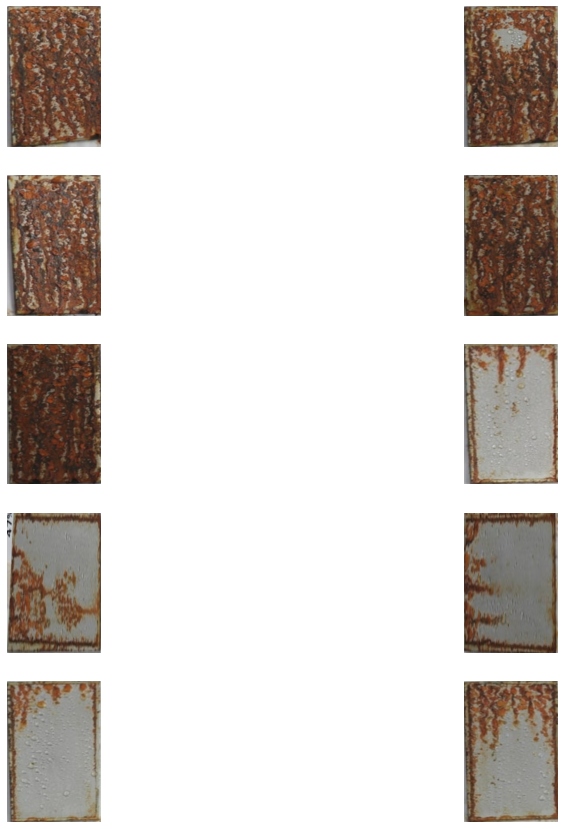

In [5]:
wrap_orig = orig.copy()
wrap = []
h = np.array([ [0,0],[199,0],[199,299],[0,299] ],np.float32)
# применяем перспективное преобразование изображений, чтобы получить ровный прямоугольник - картинку
for i, approx in enumerate(approx_best):
    approx = approx.astype(np.float32)
    transform = cv2.getPerspectiveTransform(approx, h)
    wrapped_img = cv2.warpPerspective(wrap_orig,transform,(200,300))
    wrap.append(wrapped_img)

jupyter_imshow(wrap)

<p>Отрисовываем сетку<p/>

grid size =  25
columns =  8


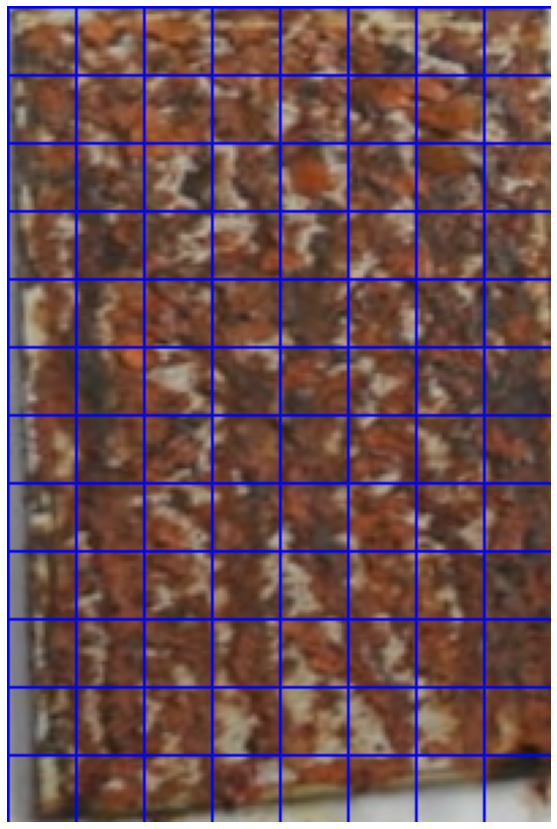

In [6]:
grid_size = find_grid_size(wrap[0])
columns = int(wrap[0].shape[1]/grid_size)
print("grid size = ", grid_size)
print("columns = ", columns)
grid_example = show_grid(wrap[0], grid_size)   
jupyter_imshow(grid_example, columns = 1)

<p>Разбиваем каждую пластинку на небольшие участки для их последующего прогона через НС<p/>

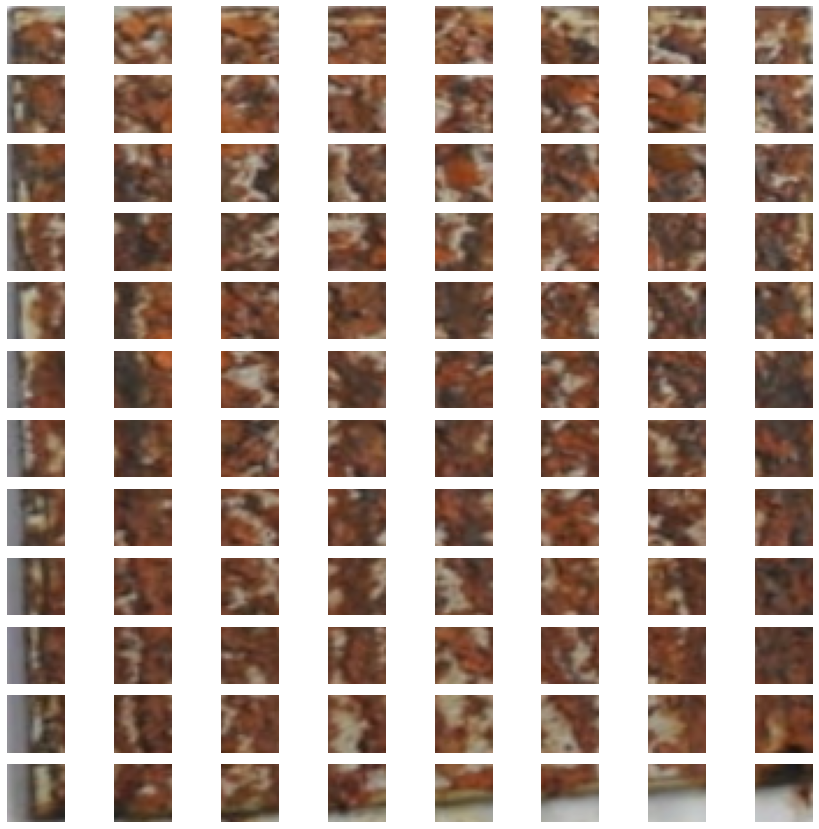

In [7]:
wrap_crops = crop_img(wrap[0], grid_size)
jupyter_imshow(wrap_crops, columns = columns)

In [8]:
rust_model = tf.keras.models.load_model('../model/')
rust_model.summary()

2022-04-01 15:51:49.611850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 15:51:49.612433: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/emelyanov/anaconda3/envs/deep_learning/lib/python3.9/site-packages/cv2/../../lib64:
2022-04-01 15:51:49.612480: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/emelyanov/anaconda3/envs/deep_learning/lib/python3.9/site-packages/cv2/../../lib64:
2022-04-01 15:51:49.612522: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load d

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 rescaling_6 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                 

non_corrosion 97.28474617004395


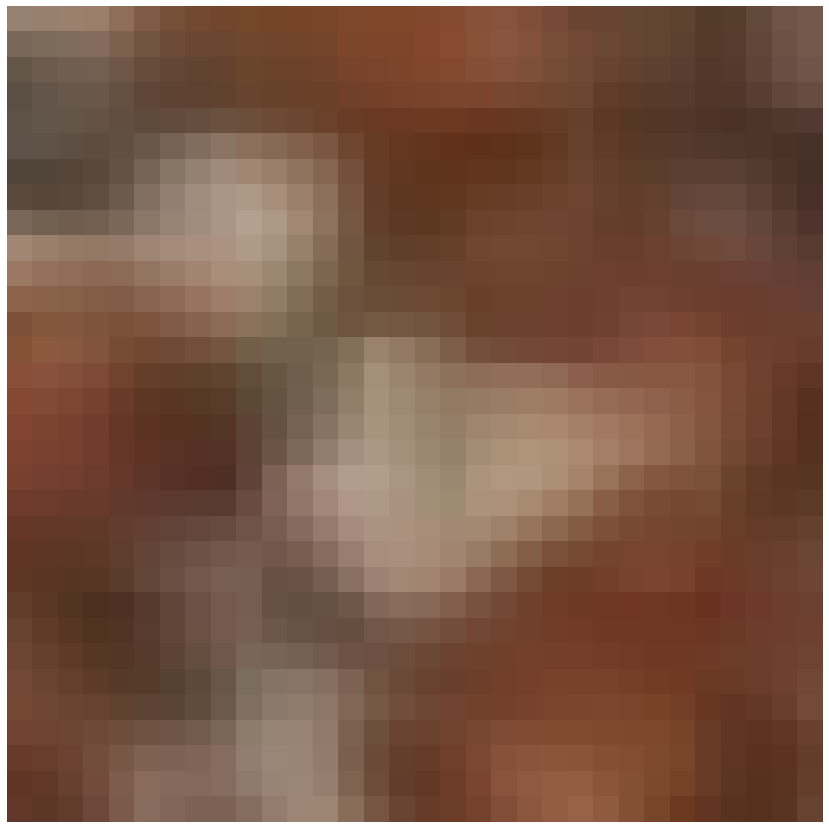

In [19]:
batch_size = 32
img_height = 32
img_width = 32

class_names = ['corrosion', 'non_corrosion']

resized = cv2.resize(wrap_crops[45], (img_height, img_width), interpolation = cv2.INTER_AREA)
img_array = tf.expand_dims(resized, 0) # Create a batch

predictions = rust_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(class_names[np.argmax(score)], 100 * np.max(score))
jupyter_imshow(resized)